In [1]:
from netCDF4 import Dataset
import cartopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
import os
import nctoolkit as nct
import regex
from matplotlib.ticker import FormatStrFormatter
from cartopy.util import add_cyclic_point
from matplotlib import colors
import geopandas as gpd
import shapely.geometry as shp

nctoolkit is using Climate Data Operators version 1.9.8


In [22]:
nct.deep_clean()

In [23]:
os.chdir('/home/users/zy1921/Ind_variables/')
print(os.getcwd())

/home/users/zy1921/Ind_variables


In [2]:
# Load multiple files at once and getting variable names

files = ['Data/Raw/intpp_Omon_CESM2_esm-ssp585_r1i1p1f1_gn_201501-206412.nc', 
        'Data/Raw/intpp_Omon_CESM2_esm-ssp585_r1i1p1f1_gn_206501-210012.nc']
#nc = nct.open_data(files)
#print(nc.variables)

names = ', '.join(files)
print(names)

variable = regex.search(r"(?<=Data/Raw/)[^_]*", names).group()
print(variable)
model = regex.search(r"(?<=Data/Raw/.*?_.*?_)[^_]*", names).group()
print(model)
experiment = regex.search(r"(?<=Data/Raw/.*?_.*?_.*?_)[^_]*", names).group()
print(experiment)

start = 2015
end = 2100

Data/Raw/intpp_Omon_CESM2_esm-ssp585_r1i1p1f1_gn_201501-206412.nc, Data/Raw/intpp_Omon_CESM2_esm-ssp585_r1i1p1f1_gn_206501-210012.nc
intpp
CESM2
esm-ssp585


In [5]:
nc.merge("time")
nc.to_latlon(lon = [-180, 180], lat = [-90, 90], res = [1,1])
nc.to_nc("Data/{}_{}_{}.nc".format(variable, model, experiment), overwrite = True)

## Sea fronts


In [3]:
fp = "Shapes/SO_fronts.shp"
shape = gpd.read_file(fp)

In [4]:
print(type(shape))

print(shape)

<class 'geopandas.geodataframe.GeoDataFrame'>
                                                name  front  \
0                                  Subtropical front    stf   
1                                 Subantarctic front    saf   
2                                        Polar front     pf   
3       Southern Antarctic circumpolar current front  saccf   
4  Southern Boundary of the Antarctic circumpolar...   sbdy   

                                            geometry  
0  MULTILINESTRING ((-179.96100 -44.47680, -178.4...  
1  LINESTRING (-179.91000 -56.84000, -179.30000 -...  
2  LINESTRING (-179.97000 -61.71000, -179.21000 -...  
3  MULTILINESTRING ((-179.65000 -64.51000, -179.3...  
4  LINESTRING (-179.13700 -65.55500, -177.93700 -...  


<AxesSubplot:>

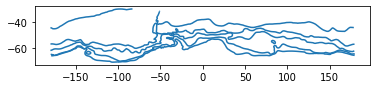

In [5]:
shape.plot()

In [6]:
shape.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

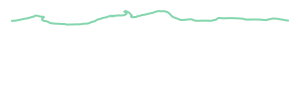

In [7]:
shape['geometry'][4]

In [8]:
front = shp.LineString(shape['geometry'][1])

In [16]:
x_coord = front.xy[0]
y_coord = front.xy[1]
print(len(x_coord))

x_coord, y_coord = np.meshgrid(x_coord, y_coord)

length = len(x_coord) * len(y_coord)
print(length)
      
z = [1] * length
z = np.array(z)
z = z.reshape((len(x_coord), len(y_coord)))

1080
1166400


In [42]:
for index, row in shape.iterrows():
    print(row['name'])
    front = row['geometry']

Subtropical front


AttributeError: 'MultiLineString' object has no attribute 'x'

## Correlation


### Temporal correlation

In [18]:
npp = nct.open_data("Data/intpp_{}_{}.nc".format(model, experiment))

exp = nct.open_data("Data/epc100_{}_{}.nc".format(model, experiment))


In [13]:
npp.current

['Data/intpp_CESM2_esm-ssp585.nc']

In [19]:
cor = nct.cor_time(npp, exp)
#cor.reduce_dims()
cor.to_nc("Data/correlation_time.nc", overwrite = True)

In [20]:
nc = Dataset("Data/correlation_time.nc")
print(nc.variables)

lat = nc.variables['lat'][:] # [:] means all elements inside the list
lon = nc.variables['lon'][:]
print(len(lat), len(lon))

var = nc.variables ['cor'][:]

var = np.nanmean(var, axis = 0)
print(var.shape)
var_max = np.amax(var)
var_min = np.amin(var)
print(var_max, var_min)


var, lon = add_cyclic_point(var, coord=lon)

x, y = np.meshgrid(lon, lat)

{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    bounds: time_bnds
    units: days since 0001-01-01 00:00:00
    calendar: 365_day
    axis: T
unlimited dimensions: time
current shape = (1,)
filling off, 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (1, 2)
filling off, 'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (361,)
filling off, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (181,)
filling off, 'cor': <class 'netCDF4._netCDF4.Variable'>
float32 cor(time, lat, lon)
    standard_name: net_primary_mole_productivity_of_biomass_expressed_as_carbon_by_phytoplankton
    long_name: Primary Org

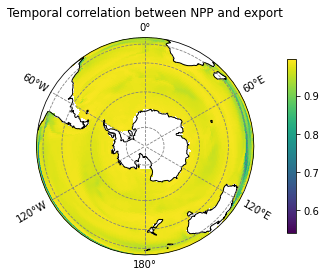

In [21]:
ax = plt.axes(projection=cartopy.crs.Orthographic(central_longitude = 0, 
                                                  central_latitude=-90))

plt.title("Temporal correlation between NPP and export")

#ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
#ax.add_feature(cartopy.feature.COASTLINE)

#divnorm = colors.TwoSlopeNorm(vmin = var_min, vcenter = 0., vmax = var_max)

p = ax.pcolor(x, y, var, 
              cmap = 'viridis', transform = cartopy.crs.PlateCarree() )

cb = plt.colorbar(p, shrink=0.8, pad = 0.1)

gl = ax.gridlines(crs = cartopy.crs.PlateCarree(),
                  draw_labels = True,
                  color = 'grey',
                  linestyle = '--') 

ax.coastlines()

plt.savefig("output/Temporal Correlation.png".format(variable, model, experiment))

plt.show()

### Spatial correlation


In [5]:
npp = nct.open_data("Data/intpp_{}_{}.nc".format(model, experiment))
exp = nct.open_data("Data/epc100_{}_{}.nc".format(model, experiment))

npp.crop(lon = [-180, 180], lat = [-90, -40])
exp.crop(lon = [-180, 180], lat = [-90, -40])

In [7]:
cor = nct.cor_space(npp, exp)

cor.to_nc("Data/correlation_space.nc", overwrite = True)

In [8]:
cor = nct.open_data("Data/correlation_space.nc")
cor.contents
cor.tmean("year")
time = cor.years

cor.to_nc("Data/correlation_over_time.nc", overwrite = True)

In [9]:
cor = nct.open_data("Data/correlation_over_time.nc")
time = cor.years

nc = Dataset("Data/correlation_over_time.nc")
print(nc.variables)

var = nc.variables ['cor'][:]

print(var)
var = np.nanmean(var, axis = 1)
var = np.nanmean(var, axis = 1)
print(var)
print(var.shape)

{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    bounds: time_bnds
    units: days since 0001-01-01 00:00:00
    calendar: 365_day
    axis: T
unlimited dimensions: time
current shape = (86,)
filling off, 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (86, 2)
filling off, 'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (1,)
filling off, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (1,)
filling off, 'cor': <class 'netCDF4._netCDF4.Variable'>
float32 cor(time, lat, lon)
    standard_name: net_primary_mole_productivity_of_biomass_expressed_as_carbon_by_phytoplankton
    long_name: Primary Organ

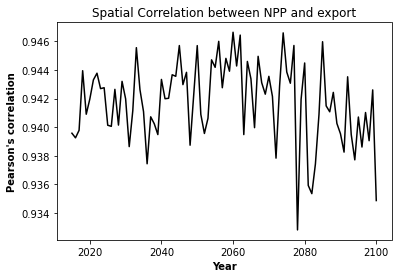

In [10]:
fig, ax = plt.subplots()

ax.plot(time, var, 'k')
ax.title.set_text("Spatial Correlation between NPP and export")

ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Pearson's correlation")
plt.xlabel("Year")

plt.savefig("Correlation between NPP and export.png".format(variable, model, experiment))

plt.show()

## Difference


### Calculation


In [16]:
# historial experiment 

historical = nct.open_data("Data/Raw/intpp_Omon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc")
print(historical.contents)

historical.to_latlon(lon = [-180, 180], lat = [-90, 90], res = [1,1])
historical.subset(year = range(1994, 2014))

historical.tmean()



new = nct.open_data("Data/{}_{}_{}.nc".format(variable, model, experiment))
print(new.contents)

new.subset(year = range(2080, 2100))
new.tmean()



new.subtract(historical)

new.reduce_dims()
new.to_nc("Data/{}_{}_difference.nc".format(variable, model), overwrite = True)


/opt/jaspy/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'intpp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
/opt/jaspy/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'intpp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.


  variable  ntimes  npoints  nlevels  \
0    intpp    1980   122880        1   

                                           long_name         unit data_type  
0  Primary Organic Carbon Production by All Types...  mol m-2 s-1      F32z  


/opt/jaspy/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'intpp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.


  variable  ntimes  npoints  nlevels  \
0    intpp    1032    65341        1   

                                           long_name         unit data_type  
0  Primary Organic Carbon Production by All Types...  mol m-2 s-1      F32z  


/home/users/zy1921/.local/lib/python3.8/site-packages/nctoolkit/add_etc.py:92: UserWarning: Use CDO>=1.9.10 for smarter operations


In [14]:
historical = nct.open_data("Data/Raw/intpp_Omon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc")
print(historical.contents)

historical.to_latlon(lon = [-180, 180], lat = [-90, 90], res = [1,1])
historical.subset(year = range(1994, 2014))

historical.tmean()

historical.to_nc("Data/{}_{}_historical_20y.nc".format(variable, model), overwrite = True)

/opt/jaspy/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'intpp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
/opt/jaspy/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'intpp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.


  variable  ntimes  npoints  nlevels  \
0    intpp    1980   122880        1   

                                           long_name         unit data_type  
0  Primary Organic Carbon Production by All Types...  mol m-2 s-1      F32z  


/opt/jaspy/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'intpp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.


In [11]:
new = nct.open_data("Data/{}_{}_{}.nc".format(variable, model, experiment))
print(new.contents)

new.subset(year = range(2080, 2100))
new.tmean()

new.to_nc("Data/{}_{}_{}_20y.nc".format(variable, model, experiment), overwrite = True)

  variable  ntimes  npoints  nlevels  \
0    intpp    1032    65341        1   

                                           long_name         unit data_type  
0  Primary Organic Carbon Production by All Types...  mol m-2 s-1      F32z  


In [17]:
new = Dataset("Data/{}_{}_historical_20y.nc".format(variable, model, experiment))
print(new.variables)
var_new = new.variables [variable][:]
print(var_new)

new = Dataset("Data/{}_{}_{}_20y.nc".format(variable, model, experiment))
print(new.variables)
var_new = new.variables [variable][:]
print(var_new)

difference = Dataset("Data/{}_{}_difference.nc".format(variable, model), overwrite = True)
print(difference.variables)

var_dif = difference.variables [variable][:]
print(var_dif)
print(np.amax(var_dif), np.amin(var_dif))

{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    bounds: time_bnds
    units: days since 0001-01-01 00:00:00
    calendar: 365_day
    axis: T
unlimited dimensions: time
current shape = (1,)
filling off, 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (1, 2)
filling off, 'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (361,)
filling off, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (181,)
filling off, 'intpp': <class 'netCDF4._netCDF4.Variable'>
float32 intpp(time, lat, lon)
    standard_name: net_primary_mole_productivity_of_biomass_expressed_as_carbon_by_phytoplankton
    long_name: Primary

### Plotting

In [12]:
nc = Dataset("Data/{}_{}_difference.nc".format(variable, model), overwrite = True)
#print(nc.variables)


lat = nc.variables['lat'][:] # [:] means all elements inside the list
lon = nc.variables['lon'][:]
print(len(lat), len(lon))


var = nc.variables [variable][:]
var_max = np.amax(var)
var_min = np.amin(var)
print(var_max, var_min)


var, lon = add_cyclic_point(var, coord=lon)

x, y = np.meshgrid(lon, lat)

181 361
2.3352035e-07 -3.5686998e-07


In [24]:
ax = plt.axes(projection=cartopy.crs.Orthographic(central_longitude = 0, 
                                                  central_latitude=-90))

plt.title("Change in NPP (mol m-2 s-1) {} 1994-2100".format(model, start))

#ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
#ax.add_feature(cartopy.feature.COASTLINE)

#divnorm = colors.TwoSlopeNorm(vmin = var_min, vcenter = 0., vmax = var_max)

#p = ax.pcolor(x, y, var, 
          #    cmap = 'coolwarm', norm = divnorm, transform = cartopy.crs.PlateCarree() )

#cb = plt.colorbar(p, shrink=0.8, pad = 0.1)

#gl = ax.gridlines(crs = cartopy.crs.PlateCarree(),
      #            draw_labels = True,
     #             color = 'grey',
       #           linestyle = '--', 
        #          y_inline = True) 

ax.coastlines()
ax.global()

ax.contour(x_coord, y_coord, z,
           levels=1,
           colors=['black'],
           transform = cartopy.crs.PlateCarree())

plt.savefig("output/{}_{}_{}_change.png".format(variable, model, experiment))

plt.show()

SyntaxError: invalid syntax (113229892.py, line 24)

## Plotting map

### Max/min value for plotting 

### Max/min value for plotting 

In [6]:
file = "Data/{}_{}_{}.nc".format(variable, model, experiment)
nc = Dataset(file)

var = nc.variables [variable][:]
max_var = np.amax(var)
min_var = np.amin(var)

print(max_var)
print(min_var)

3.774536e-06
0.0


### 2015

In [7]:
data = nct.open_data("Data/{}_{}_{}.nc".format(variable, model, experiment))
data.select(year = start)
data.tmean()
data.to_nc("Data/{}_{}_{}_{}.nc".format(variable, model, experiment, start), overwrite = True)

In [8]:
file = "Data/{}_{}_{}_{}.nc".format(variable, model, experiment, start)
nc = Dataset(file)
print(nc.variables)

{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    bounds: time_bnds
    units: days since 0001-01-01 00:00:00
    calendar: 365_day
    axis: T
unlimited dimensions: time
current shape = (1,)
filling off, 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (1, 2)
filling off, 'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (361,)
filling off, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (181,)
filling off, 'intpp': <class 'netCDF4._netCDF4.Variable'>
float32 intpp(time, lat, lon)
    standard_name: net_primary_mole_productivity_of_biomass_expressed_as_carbon_by_phytoplankton
    long_name: Primary

In [9]:
lat = nc.variables['lat'][:] # [:] means all elements inside the list
lon = nc.variables['lon'][:]
var = nc.variables [variable][:]

mean_var = np.nanmean(var, axis = 0) 
print(mean_var.shape) 

x, y = np.meshgrid(lon, lat)

(181, 361)


shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


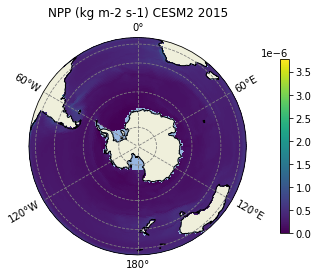

In [10]:
ax = plt.axes(projection=cartopy.crs.Orthographic(central_longitude = 0, 
                                                  central_latitude=-90))

plt.title("NPP (mol m-2 s-1) {} {}".format(model, start))
    
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)


p = ax.pcolor(x, y, mean_var, vmax = max_var, vmin = min_var, 
              transform = cartopy.crs.PlateCarree() )

cb = plt.colorbar(p, shrink=0.8, pad = 0.1)

gl = ax.gridlines(crs = cartopy.crs.PlateCarree(),
                  draw_labels = True,
                  color = 'grey',
                  linestyle = '--') 


plt.savefig("output/{}_{}_{}_{}.png".format(variable, model, experiment, start))

plt.show()


### 2100

In [11]:
data = nct.open_data("Data/{}_{}_{}.nc".format(variable, model, experiment))
data.select(year = end)
data.tmean()
data.to_nc("Data/{}_{}_{}_{}.nc".format(variable, model, experiment, end), overwrite = True)

In [12]:
file = "Data/{}_{}_{}_{}.nc".format(variable, model, experiment, end)
nc = Dataset(file)
print(nc.variables)

{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    bounds: time_bnds
    units: days since 0001-01-01 00:00:00
    calendar: 365_day
    axis: T
unlimited dimensions: time
current shape = (1,)
filling off, 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (1, 2)
filling off, 'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (361,)
filling off, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (181,)
filling off, 'intpp': <class 'netCDF4._netCDF4.Variable'>
float32 intpp(time, lat, lon)
    standard_name: net_primary_mole_productivity_of_biomass_expressed_as_carbon_by_phytoplankton
    long_name: Primary

In [13]:
lat = nc.variables['lat'][:] # [:] means all elements inside the list
lon = nc.variables['lon'][:]
var = nc.variables [variable][:]

mean_var = np.nanmean(var, axis = 0) 
print(mean_var.shape) 

x, y = np.meshgrid(lon, lat)

(181, 361)


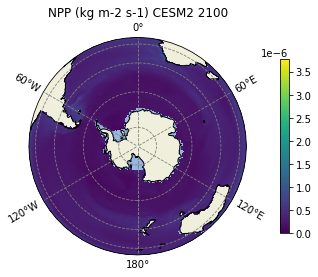

In [14]:
ax = plt.axes(projection=cartopy.crs.Orthographic(central_longitude = 0, 
                                                  central_latitude=-90))

plt.title("NPP (mol m-2 s-1) {} {}".format(model, end))
    
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)


p = ax.pcolor(x, y, mean_var, vmax = max_var, vmin = min_var, 
              transform = cartopy.crs.PlateCarree() )

cb = plt.colorbar(p, shrink=0.8, pad = 0.1)

gl = ax.gridlines(crs = cartopy.crs.PlateCarree(),
                  draw_labels = True,
                  color = 'grey',
                  linestyle = '--') 


plt.savefig("output/{}_{}_{}_{}.png".format(variable, model, experiment, end))

plt.show()


## Time series

In [15]:
# Join the two files with time 

data = nct.open_data("Data/{}_{}_{}.nc".format(variable, model, experiment))

time = data.years
time = tuple(time)
len(time)

86

In [16]:
# Select regions 40S south 

data.crop(lon = [-180, 180], lat = [-90, -40])

data.assign(space = lambda x: spatial_mean(x.intpp), drop = True)
data.rename({"space":"{}".format(variable)})
print(data.variables_detailed)

data.to_nc("Data/{}_{}_{}_40S.nc".format(variable, model, experiment), overwrite = True)

  variable  levels  points                                          long_name  \
0    intpp       1   65341  Primary Organic Carbon Production by All Types...   

         units  
0  mol m-2 s-1  


In [17]:
!cdo -yearmean Data/{variable}_{model}_{experiment}_40S.nc Data/{variable}_{model}_{experiment}_40S_mean.nc

cdo    yearmean: Processed 1 variable over 1117 timesteps [0.17s 220MB].


In [18]:
# Load new file: 
nc = Dataset("Data/{}_{}_{}_40S_mean.nc".format(variable, model, experiment))
print(nc.variables)
var_mean = nc.variables[variable][:]
print(var_mean.shape)
time_mean= nc.variables['time'][:]

{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    bounds: time_bnds
    units: days since 0001-01-01 00:00:00
    calendar: 365_day
    axis: T
unlimited dimensions: time
current shape = (86,)
filling off, 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (86, 2)
filling off, 'intpp': <class 'netCDF4._netCDF4.Variable'>
float32 intpp(time)
    _FillValue: 1e+20
    missing_value: 1e+20
    cell_methods: time: mean
unlimited dimensions: time
current shape = (86,)
filling off}
(86,)


In [19]:
!cdo -yearmax Data/{variable}_{model}_{experiment}_40S.nc Data/{variable}_{model}_{experiment}_40S_max.nc
!cdo -yearmin Data/{variable}_{model}_{experiment}_40S.nc Data/{variable}_{model}_{experiment}_40S_min.nc

cdo    yearmax: Processed 1 variable over 1117 timesteps [0.14s 220MB].
cdo    yearmin: Processed 1 variable over 1117 timesteps [0.15s 220MB].


In [20]:
# Load new file: 
nc = Dataset("Data/{}_{}_{}_40S_min.nc".format(variable, model, experiment))
             
var_min = nc.variables[variable][:]
time_min= nc.variables['time'][:]

print(var_min.shape)

(86,)


In [21]:
# Load new file: 
nc = Dataset("Data/{}_{}_{}_40S_max.nc".format(variable, model, experiment))
             
var_max = nc.variables[variable][:]
time_max= nc.variables['time'][:]

print(var_max.shape)

(86,)


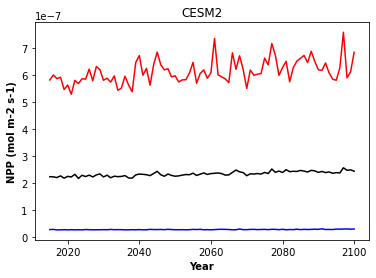

In [24]:
fig, ax = plt.subplots()

ax.plot(time, var_mean, 'k')
ax.plot(time, var_max, 'r')
ax.plot(time, var_min, 'b')

ax.title.set_text("{}".format(model))

ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("NPP (mol m-2 s-1)")
plt.xlabel("Year")

plt.savefig("output/{}_{}_{}_projection.png".format(variable, model, experiment))

plt.show()